In [ ]:
import torch
import torchaudio
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.utils.prune as prune
# from Pipeline import *
from torchvision import transforms,datasets
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict



def load_cifar10(data_dir, train=True):
    images = []
    labels = []
    if train:
        file_prefix = 'data_batch'
        for batch_file in os.listdir(data_dir):
              if batch_file.startswith('data_batch'):
                  batch_data = unpickle(os.path.join(data_dir, batch_file))
                  images.append(batch_data['data'])
                  labels.append(batch_data['labels'])
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)



    else:
        file_prefix = 'test_batch'
        batch_file = os.path.join(data_dir, file_prefix)
        batch_data = unpickle(batch_file)
        images.append(batch_data['data'])
        labels.append(batch_data['labels'])
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)


    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    # one_hot_encoder = OneHotEncoder(sparse=False)
    # labels = one_hot_encoder.fit_transform(encoded_labels.reshape(-1, 1))
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return images, labels






def read_file_paths(file_path,root):
    with open(file_path, 'r') as f:
        file_paths = f.readlines()
    file_paths = [os.path.join(root,path.strip()) for path in file_paths]
    return file_paths



def get_training_files(directory,testing_file_paths,validation_file_paths):
    training_file_paths=[]
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_path=file_path.replace("\\", "/")

            # print(file_path)
            if file_path not in testing_file_paths and file_path not in validation_file_paths and file_path.split('/')[4]!="_background_noise_":
                if  root!="./data/SpeechCommands/speech_commands_v0.02":
                    training_file_paths.append(file_path)
    return training_file_paths



def iterate_dataset(dataset):
    data_list = []
    labels_list = []
    cnt=0
    for curr_sample in dataset:
        cnt+=1
        if cnt%10000==0: print(cnt)

        data=curr_sample[0]
        label=curr_sample[2]
        data_list.append(data)
        labels_list.append(label)


    encoded_labels = LabelEncoder.fit_transform(labels_list)
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(encoded_labels))
    padded_data = pad_sequence(data_list, batch_first=True)

    data_tensor = torch.tensor(padded_data)
    labels_tensor = torch.tensor(labels_list)

    return data_tensor, labels_tensor



# def load_audio_data(file_paths):
#     audio_data = []
#     labels = []
#     for file_path in file_paths:
#         waveform, sample_rate = torchaudio.load(file_path)
#         label = os.path.basename(os.path.dirname(file_path))
#         audio_data.append(waveform.numpy())
#         labels.append(label)
#     return np.array(audio_data), np.array(labels)








# IMAGE-  CIFAR-10 dataset
transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_directory = "./data/cifar-10-batches-py"
if os.path.exists(data_directory):
    pass
else:
    image_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_image)
    image_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_image)


train_images, train_labels = load_cifar10(data_directory, train=True)
test_images, test_labels = load_cifar10(data_directory, train=False)
train_size = 40000
val_size = 10000
image_train_data, image_val_data, image_train_labels, image_val_labels = train_test_split(train_images, train_labels, test_size=10000, random_state=42)
image_test_data,image_test_labels=test_images,test_labels

image_datasets_dict={"train":[image_train_data,image_train_labels],"val":[image_val_data,image_val_labels],"test":[image_test_data,image_test_labels]}






# Audio- Speech command dataset v0.02
# transform_audio = transforms.Compose([
#     torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=128),
#     torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
#     torchaudio.transforms.TimeMasking(time_mask_param=35)
# ])

# data_directory = "./data/speech_commands"
# if os.path.exists(data_directory): speech_commands_dataset = SPEECHCOMMANDS(root=data_directory, download=False)
# else: speech_commands_dataset = SPEECHCOMMANDS(root="./data", download=True)

# root_dir="./data/SpeechCommands/speech_commands_v0.02"
# audio_testing_file_paths = read_file_paths("./data/SpeechCommands/speech_commands_v0.02/testing_list.txt",root_dir)
# audio_validation_file_paths = read_file_paths("./data/SpeechCommands/speech_commands_v0.02/validation_list.txt",root_dir)
# audio_training_file_paths=get_training_files(root_dir,audio_testing_file_paths,audio_validation_file_paths)

# audio_train_data, audio_train_labels = load_audio_data(audio_training_file_paths) # Load audio data and labels for training, validation, and testing sets
# audio_val_data, audio_val_labels = load_audio_data(audio_validation_file_paths)
# audio_test_data, audio_test_labels = load_audio_data(audio_testing_file_paths)

# audio_datasets_dict={"train":[audio_train_data,audio_train_labels],"val":[audio_val_data,audio_val_labels],"test":[audio_test_data,audio_test_labels]}





class ImageDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "test", "val"]:
            raise Exception("Data split must be in [train, test, val]")

        self.datasplit = split
        self.images=image_datasets_dict[split][0]
        self.labels=image_datasets_dict[split][1]
        self.transform=transform_image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]                     #image is already transformed
        if self.transform is not None:
            image = self.transform(image)
        label=self.labels[idx]
        return (image, label)





# class AudioDataset(Dataset):
#     def __init__(self, split:str="train") -> None:
#         super().__init__()
#         if split not in ["train", "test", "val"]:
#             raise Exception("Data split must be in [train, test, val]")

#         self.datasplit = split
#         self.audios=audio_datasets_dict[split][0]
#         self.labels=audio_datasets_dict[split][1]
#         self.transform=transform_audio

#     def __len__(self):
#         return len(self.audios)

#     def __getitem__(self, idx):
#         audio=self.audios[idx]
#         if self.transform is not None:
#             audio = self.transform(audio)
#         label=self.labels[idx]
#         return (audio, label)





def find_checkpoint_dir(network,dataloader):
    Type="image"
    if isinstance(network, Resnet_Q1):
        checkpoint_dir="./checkpoints/Resnet_Q1/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        # elif isinstance(dataloader.dataset,AudioDataset):
        #     checkpoint_dir+="audio/"
        #     Type="audio"
        else: print("check_dir error")

    elif isinstance(network, VGG_Q2):
        checkpoint_dir="./checkpoints/VGG_Q2/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        # elif isinstance(dataloader.dataset,AudioDataset):
        #     checkpoint_dir+="audio/"
        #     Type="audio"
        else: print("check_dir error")

    elif isinstance(network, Inception_Q3):
        checkpoint_dir="./checkpoints/Inception_Q3/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        # elif isinstance(dataloader.dataset,AudioDataset):
        #     checkpoint_dir+="audio/"
        #     Type="audio"
        else: print("check_dir error")

    elif isinstance(network, CustomNetwork_Q4):
        checkpoint_dir="./checkpoints/CustomNetwork_Q4/"
        if isinstance(dataloader.dataset,ImageDataset):
            checkpoint_dir+="image/"
        # elif isinstance(dataloader.dataset,AudioDataset):
        #     checkpoint_dir+="audio/"
        #     Type="audio"
        else: print("check_dir error")

    else: print("check_dir error")

    return checkpoint_dir,Type



def apply_pruning(model, pruning_method, amount):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=amount, n=2, dim=0, pruning_method=pruning_method)

def remove_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.remove(module, 'weight')

100%|██████████| 170498071/170498071 [00:05<00:00, 29681481.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# IMAGE-  CIFAR-10 dataset
image_label_to_name= {0: ('airplane', 0), 1: ('automobile', 1), 2: ('bird', 2), 3: ('cat', 3), 4: ('deer', 4), 5: ('dog', 5), 6: ('frog', 6), 7: ('horse', 7), 8: ('ship', 8), 9: ('truck', 9)}

transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_directory = "./data/cifar-10-batches-py"
if os.path.exists(data_directory):
    pass
else:
    image_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_image)
    image_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_image)


train_images, train_labels = load_cifar10(data_directory, train=True)
test_images, test_labels = load_cifar10(data_directory, train=False)
train_size = 40000
val_size = 10000
image_train_data, image_val_data, image_train_labels, image_val_labels = train_test_split(train_images, train_labels, test_size=10000, random_state=42)
image_test_data,image_test_labels=test_images,test_labels

image_datasets_dict={"train":[image_train_data,image_train_labels],"val":[image_val_data,image_val_labels],"test":[image_test_data,image_test_labels]}


In [ ]:


# Audio- Speech command dataset v0.02
transform_audio = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
])

data_directory = "./data/speech_commands"
if os.path.exists(data_directory): speech_commands_dataset = SPEECHCOMMANDS(root=data_directory, download=False)
else: speech_commands_dataset = SPEECHCOMMANDS(root="./data", download=True)

root_dir="./data/SpeechCommands/speech_commands_v0.02"


dataset_size = len(speech_commands_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

audio_train_set, audio_val_set, audio_test_set = random_split(speech_commands_dataset, [train_size, val_size, test_size])
audio_train_data, audio_train_labels = iterate_dataset(audio_train_set)
audio_val_data, audio_val_labels = iterate_dataset(audio_val_set)
audio_test_data, audio_test_labels = iterate_dataset(audio_test_set)


# audio_testing_file_paths = read_file_paths("./data/SpeechCommands/speech_commands_v0.02/testing_list.txt",root_dir)
# audio_validation_file_paths = read_file_paths("./data/SpeechCommands/speech_commands_v0.02/validation_list.txt",root_dir)
# audio_training_file_paths=get_training_files(root_dir,audio_testing_file_paths,audio_validation_file_paths)

# audio_train_data, audio_train_labels = load_audio_data(audio_training_file_paths) # Load audio data and labels for training, validation, and testing sets
# audio_val_data, audio_val_labels = load_audio_data(audio_validation_file_paths)
# audio_test_data, audio_test_labels = load_audio_data(audio_testing_file_paths)

audio_datasets_dict={"train":[audio_train_data,audio_train_labels],"val":[audio_val_data,audio_val_labels],"test":[audio_test_data,audio_test_labels]}


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "test", "val"]:
            raise Exception("Data split must be in [train, test, val]")

        self.datasplit = split
        self.images=image_datasets_dict[split][0]
        self.labels=image_datasets_dict[split][1]
        self.transform=transform_image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]                     #image is already transformed
        if self.transform is not None:
            image = self.transform(image)
        label=self.labels[idx]
        return (image, label)





class AudioDataset(Dataset):
    def __init__(self, split:str="train") -> None:
        super().__init__()
        if split not in ["train", "test", "val"]:
            raise Exception("Data split must be in [train, test, val]")

        self.datasplit = split
        self.audios=audio_datasets_dict[split][0]
        self.labels=audio_datasets_dict[split][1]
        self.transform=transform_audio

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        audio=self.audios[idx]
        if self.transform is not None:
            audio = self.transform(audio)
        label=self.labels[idx]
        return (audio, label)

<br><br><br>
<h3> Visualize Images </h3>

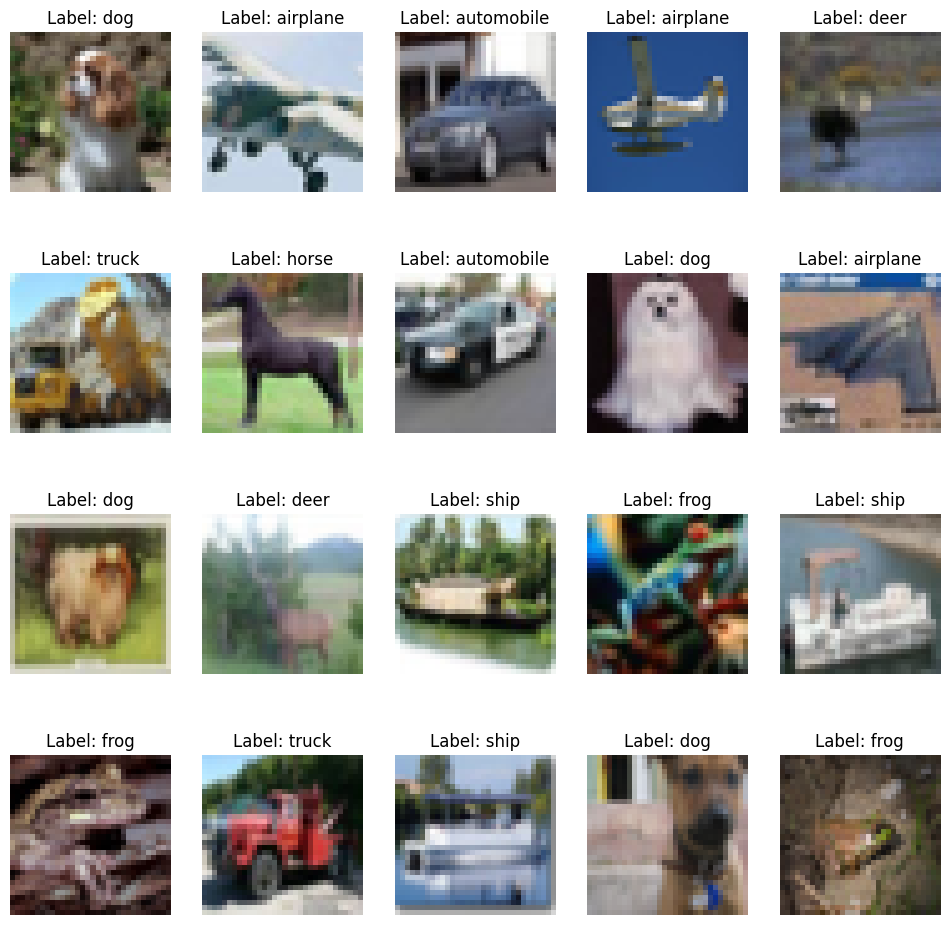

In [ ]:
def display_random_images(image_train_data,image_train_labels):
    num_images_to_display = 20
    num_rows = 4
    num_cols = num_images_to_display // num_rows

    random_indices = torch.randperm(len(image_train_data))[:num_images_to_display]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = random_indices[i * num_cols + j]
            image= image_train_data[index]
            label= image_train_labels[index]
            # print(label)
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title(f'Label: {image_label_to_name[label][0]}')
            axes[i, j].axis('off')
    plt.show()




display_random_images(image_train_data,image_train_labels)

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1,Type=""):
        super(BasicBlock, self).__init__()
        if (Type=="image"):
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )


        elif (Type=="audio"):
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm1d(out_channels)
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm1d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels)
                )

        else:
            print('FATAL ERROR')



    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class Resnet_Q1(nn.Module):
    def __init__(self, num_classes=10,Type="image") -> None:
        super().__init__()
        num_blocks=[6,6,6]
        self.in_channels = 3

        if Type=="image":
            self.layer1 = self._make_layer(64, num_blocks[0],2,Type)
            self.layer2 = self._make_layer(128, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(256, num_blocks[2],2,Type)
            # self.layer4 = self._make_layer(512, num_blocks[3],2,Type)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        elif Type=="audio":
            self.layer1 = self._make_layer(64, num_blocks[0],1,Type)
            self.layer2 = self._make_layer(128, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(256, num_blocks[2],2,Type)
            # self.layer4 = self._make_layer(512, num_blocks[3],2,Type)
            self.avgpool = nn.AdaptiveAvgPool1d((1, 1))

        self.linear = nn.Linear(256, num_classes)
        self.relu=nn.ReLU()


    def _make_layer(self, out_channels, num_blocks, stride,Type):
        strides = [stride]*num_blocks
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride,Type))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



max_acc_epoch=0
def trainer(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)
    if Type=="audio":
       network=Resnet_Q1(Type="audio")


    accuracies=[]
    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)

    # Write your code here
    for epoch in range(EPOCH):
        total_loss, correct, total = 0, 0, 0
        # cnt=0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            # if (cnt%50==0): print(cnt)
            # cnt+=1
            outputs = network(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            # print(loss)
            loss.backward()  # backpropagates the losses
            # print('hello')
            optimizer.step() # updates all the gradients of previous layers
            # print('hello2')
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        loss = total_loss/len(dataloader)
        accuracy = correct / total

        print("Training Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))
        accuracies.append(accuracy)



        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_dir+f'checkpoint_epoch_{epoch+1}.pt')




    max_acc_epoch=accuracies.index(max(accuracies))+1







def validator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)



    # Write your code here
    for epoch in range(EPOCH):

        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad(): # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in dataloader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = network(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        loss = val_loss/len(dataloader)
        accuracy = val_correct / val_total

        print("Validation Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))






def evaluator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    criterion = nn.CrossEntropyLoss()
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    network = network.to(device)


    # Write your code here
    for epoch in range(EPOCH):
        test_loss,test_correct,test_total=0,0,0

        with torch.no_grad():
            for test_inputs, test_labels in dataloader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                test_outputs = network(test_inputs)
                test_loss += criterion(test_outputs, test_labels).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()

        loss = test_loss/len(dataloader)
        accuracy = test_correct / test_total

        print("[Loss: {}, Accuracy: {}]".format(loss,accuracy))




Alternate trainer validator code so i get the result together

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1,Type=""):
        super(BasicBlock, self).__init__()
        if (Type=="image"):
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )


        elif (Type=="audio"):
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm1d(out_channels)
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm1d(out_channels)
            self.relu = nn.ReLU()

            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels)
                )

        else:
            print('FATAL ERROR')



    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class Resnet_Q1(nn.Module):
    def __init__(self, num_classes=10,Type="image") -> None:
        super().__init__()
        num_blocks=[6,6,6]
        self.in_channels = 3

        if Type=="image":
            self.layer1 = self._make_layer(64, num_blocks[0],2,Type)
            self.layer2 = self._make_layer(128, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(256, num_blocks[2],2,Type)
            # self.layer4 = self._make_layer(512, num_blocks[3],2,Type)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        elif Type=="audio":
            self.layer1 = self._make_layer(64, num_blocks[0],1,Type)
            self.layer2 = self._make_layer(128, num_blocks[1],2,Type)
            self.layer3 = self._make_layer(256, num_blocks[2],2,Type)
            # self.layer4 = self._make_layer(512, num_blocks[3],2,Type)
            self.avgpool = nn.AdaptiveAvgPool1d((1, 1))

        self.linear = nn.Linear(256, num_classes)
        self.relu=nn.ReLU()


    def _make_layer(self, out_channels, num_blocks, stride,Type):
        strides = [stride]*num_blocks
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride,Type))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



max_acc_epoch=0
def trainer(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    os.makedirs(os.path.dirname(checkpoint_dir), exist_ok=True)
    if Type=="audio":
       network=Resnet_Q1(Type="audio")


    accuracies=[]
    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)

    # Write your code here
    for epoch in range(EPOCH):
        total_loss, correct, total = 0, 0, 0
        # cnt=0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            # if (cnt%50==0): print(cnt)
            # cnt+=1
            outputs = network(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            # print(loss)
            loss.backward()  # backpropagates the losses
            # print('hello')
            optimizer.step() # updates all the gradients of previous layers
            # print('hello2')
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        loss = total_loss/len(dataloader)
        accuracy = correct / total

        print("Training Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))
        accuracies.append(accuracy)



        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_dir+f'checkpoint_epoch_{epoch+1}.pt')




    max_acc_epoch=accuracies.index(max(accuracies))+1







def validator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")
    network = network.to(device)



    # Write your code here
    for epoch in range(EPOCH):

        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad(): # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in dataloader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = network(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        loss = val_loss/len(dataloader)
        accuracy = val_correct / val_total

        print("Validation Epoch: {}, [Loss: {}, Accuracy: {}]".format(epoch+1,loss,accuracy))






def evaluator(gpu="T",dataloader=None,network=None,criterion=None,optimizer=None):

    device = torch.device("cuda:0") if gpu == "T" else torch.device("cpu")

    checkpoint_dir,Type=find_checkpoint_dir(network,dataloader)
    checkpoint=torch.load(checkpoint_dir+f"checkpoint_epoch_{max_acc_epoch}.pt")
    criterion = nn.CrossEntropyLoss()
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    network = network.to(device)


    # Write your code here
    for epoch in range(EPOCH):
        test_loss,test_correct,test_total=0,0,0

        with torch.no_grad():
            for test_inputs, test_labels in dataloader:
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                test_outputs = network(test_inputs)
                test_loss += criterion(test_outputs, test_labels).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()

        loss = test_loss/len(dataloader)
        accuracy = test_correct / test_total

        print("[Loss: {}, Accuracy: {}]".format(loss,accuracy))




In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCH = 64

In [ ]:



if __name__ == "__main__":

    imageDataset = [
        ImageDataset(split="train"),
        ImageDataset(split="val"),
        ImageDataset(split="test")

    ]

    audioDataset = [
        AudioDataset(split="train"),
        AudioDataset(split="val"),
        AudioDataset(split="test")
    ]

    Architectures = [
        Resnet_Q1(),
        VGG_Q2(),
        Inception_Q3(),
        CustomNetwork_Q4()
    ]


    for network in Architectures:

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(
            params=network.parameters(),
            lr=LEARNING_RATE
        )

        for dataset in imageDataset:# + audioDataset:
            if dataset.datasplit == "train":
                print(
                    "Training {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.train()
                train_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )

                trainer(
                    gpu='T',
                    dataloader=train_dataloader,
                    network=network,
                    criterion=criterion,
                    optimizer=optimizer
                )

            elif dataset.datasplit == "val":
                print(
                    "Validating {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.train()
                val_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )

                validator(
                    gpu='T',
                    dataloader=val_dataloader,
                    network=network,
                    criterion=criterion,
                    optimizer=optimizer
                )

            elif dataset.datasplit == "test":
                print(
                    "Testing {} Architecture on {} split of {}".format(
                        network.__class__.__name__,
                        dataset.datasplit,
                        dataset.__class__.__name__
                    )
                )
                network.eval()
                test_dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=2,
                    drop_last=True
                )
                evaluator(
                    gpu='T',
                    dataloader=test_dataloader,
                    network=network,
                    criterion=None,
                    optimizer=None)


Training Resnet_Q1 Architecture on train split of ImageDataset
Training Epoch: 1, [Loss: 1.9598499674063463, Accuracy: 0.26427283653846156]
Training Epoch: 2, [Loss: 1.6383417768356128, Accuracy: 0.39701021634615385]
Training Epoch: 3, [Loss: 1.4550981708826163, Accuracy: 0.4753104967948718]
Training Epoch: 4, [Loss: 1.3182827115823061, Accuracy: 0.5320262419871795]
Training Epoch: 5, [Loss: 1.1912524591271694, Accuracy: 0.5816806891025641]
Training Epoch: 6, [Loss: 1.0934858918190002, Accuracy: 0.6212940705128205]
Training Epoch: 7, [Loss: 1.0135163569297545, Accuracy: 0.6545723157051282]
Training Epoch: 8, [Loss: 0.9264457476062652, Accuracy: 0.6833934294871795]
Training Epoch: 9, [Loss: 0.840674665875924, Accuracy: 0.7177483974358975]
Training Epoch: 10, [Loss: 0.7871851378526443, Accuracy: 0.7361278044871795]
Training Epoch: 11, [Loss: 0.7210844019666697, Accuracy: 0.7608423477564102]
Training Epoch: 12, [Loss: 0.6781854623785386, Accuracy: 0.7747646233974359]
Training Epoch: 13, [

In [ ]:
 import torch
 device = torch.device("cuda:0")